# peak demand time


In [ ]:
import pandas as pd
data=pd.read_csv("/content/historical_consumption.csv")

In [ ]:
data.columns

Index(['session_id', 'start', 'stop', 'last_nonzero_power_time', 'energy_wh',
       'station_id', 'plug_id'],
      dtype='object')

In [ ]:
data['start'].isnull().sum()

412

In [ ]:
data1=data.dropna(subset=['start'])

In [ ]:
df = pd.DataFrame(data1)


In [ ]:
# Convert 'start' to datetime, handling errors
df['start'] = pd.to_datetime(df['start'], errors='coerce')



In [ ]:
# Extract the hour from 'start'
df['hour'] = df['start'].dt.hour

In [ ]:
# Count the number of occurrences of each hour
hourly_counts = df['hour'].value_counts().reset_index()
hourly_counts.columns = ['hour', 'count']
print(hourly_counts)

    hour  count
0    8.0     75
1   16.0     55
2   17.0     46
3   19.0     42
4   14.0     41
5   18.0     40
6   12.0     35
7   11.0     32
8    9.0     32
9   15.0     31
10  13.0     28
11  10.0     25
12   7.0     17
13  21.0     17
14  20.0     15
15  22.0     11
16  23.0      9
17   0.0      2
18   1.0      1
19   2.0      1
20   3.0      1


In [ ]:
# Find the hour with the maximum count
peak_demand_hour = hourly_counts.loc[hourly_counts['count'].idxmax()]

print("Peak demand hour:")
print(peak_demand_hour)

Peak demand hour:
hour      8.0
count    75.0
Name: 0, dtype: float64


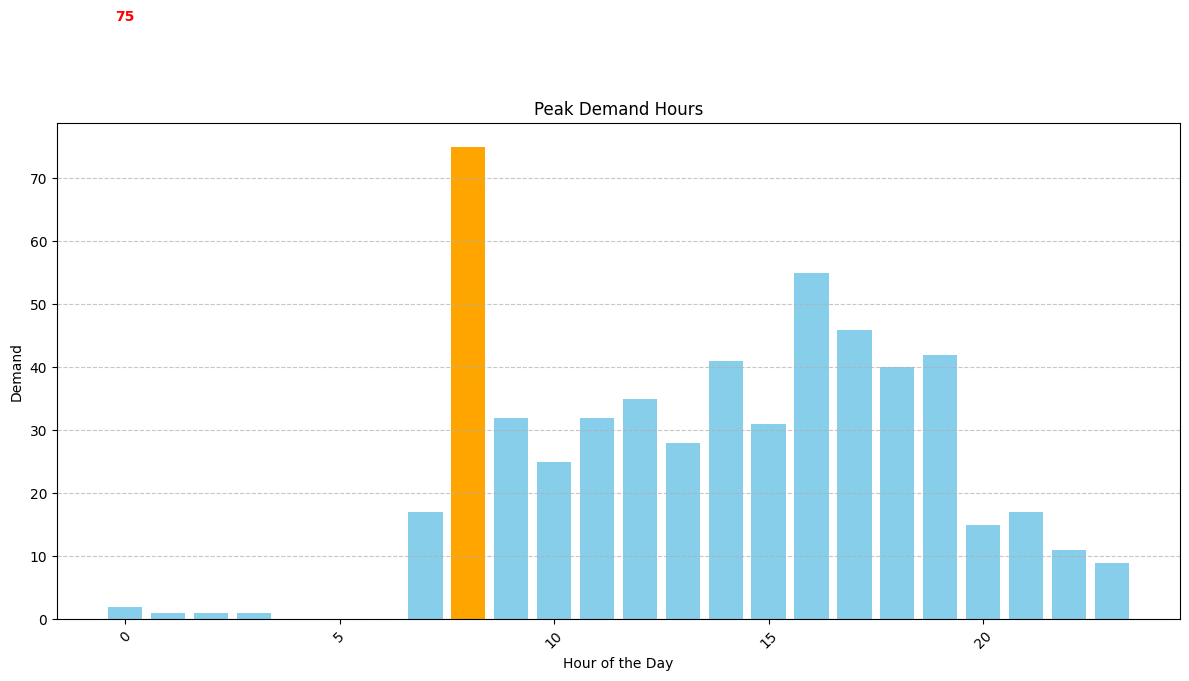

In [ ]:
import matplotlib.pyplot as plt
h=hourly_counts['hour']
occurence=hourly_counts['count']
# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(h, occurence, color='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Demand')
plt.title('Peak Demand Hours')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Highlight the peak demand hour(s)
peak_demand = max(occurence)
for i, v in enumerate(occurence):
    if v == peak_demand:
        plt.text(i, v + 20, f'{v}', ha='center', color='red', fontweight='bold')
        plt.bar(h[i], v, color='orange')  # Highlight the peak bar

plt.show()

# availibility

In [ ]:
# Extract the 'hour' column as a Series
hours = hourly_counts['hour']

# Find the hour(s) with the minimum count
inactive_hours = hours[hours == hours.min()]
print(inactive_hours)

17    0.0
Name: hour, dtype: float64


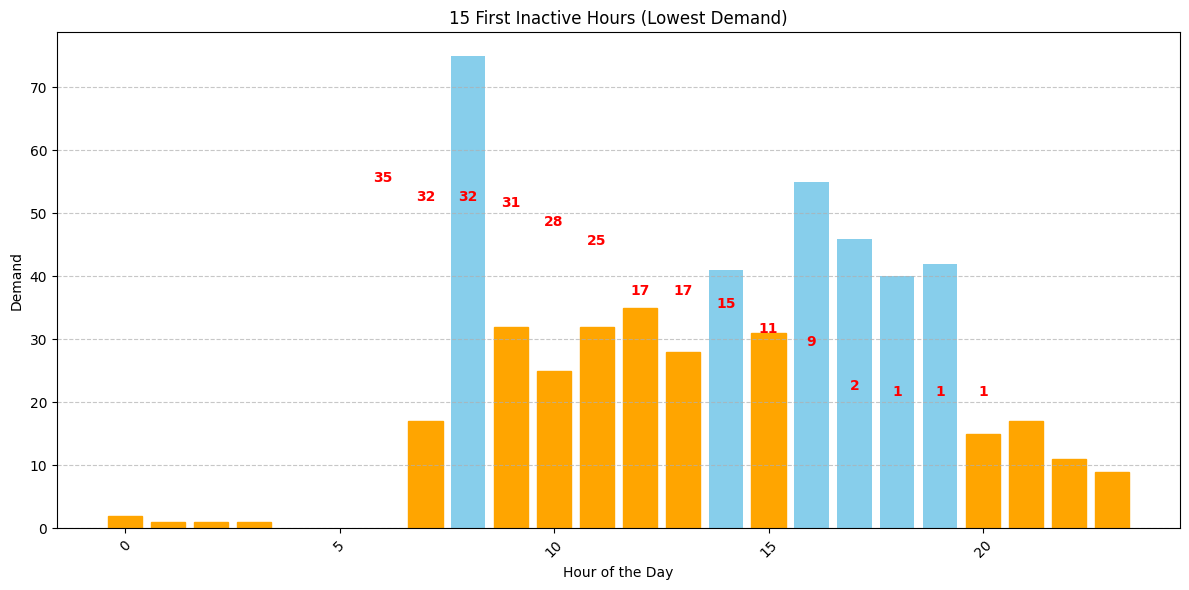

In [ ]:
import numpy as np
# Find the indices of the 10 hours with the lowest demand
lowest_demand_indices = np.argsort(occurence)[:15]

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(h, occurence, color='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Demand')
plt.title('15 First Inactive Hours (Lowest Demand)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Highlight the 10 lowest demand hours
for i in lowest_demand_indices:
    plt.text(i, occurence[i] + 20, f'{occurence[i]}', ha='center', color='red', fontweight='bold')
    bars[i].set_color('orange')  # Highlight the inactive bars

plt.show()

# power delivered

In [ ]:
import pandas as pd
dt=pd.read_csv("/content/plugs_eco_mouvement.csv")


In [ ]:
dt.columns

Index(['station_id ', 'station_name', 'location_country', 'location_city',
       'location_address', 'location_postal_code', 'location_coordinates',
       'operator_website', 'location_time_zone', 'date_start_operation',
       'location_last_updated', 'evse_id', 'evse_id_eMI3',
       'evse_physical_reference', 'evse_last_updated', 'plug _id', 'plug_type',
       'plug_power_type', 'plug_voltage', 'plug_amperage', 'plug_max_power',
       'plug_last_updated'],
      dtype='object')

In [ ]:
import pandas as pd

# Assuming df['start'] and df['stop'] are strings in the format 'YYYY-MM-DD HH:MM:SS'
df['start'] = pd.to_datetime(df['start'], utc=True)
df['stop'] = pd.to_datetime(df['stop'], utc=True)

# Now you can calculate the duration
df['duration_hours'] = (df['stop'] - df['start']).dt.total_seconds() / 3600
print(df['duration_hours'])

0      3.167563
1      2.701501
2      0.440541
3      7.630552
4      0.025328
         ...   
583    0.594228
584    2.057748
585    0.388769
586    1.617245
587    3.648194
Name: duration_hours, Length: 588, dtype: float64


In [ ]:
df['energy_delivered_kWh'] = df['duration_hours'] * dt['plug_max_power']


In [ ]:
energy_delivered_per_station = df.groupby('station_id')['energy_delivered_kWh'].sum().reset_index()
print(energy_delivered_per_station)

         station_id  energy_delivered_kWh
0    FR000011062174          43573.001213
1    FR000012292701          48238.003840
2    FR000012308585          14964.300462
3    FR000012616553          71788.232693
4    FR000028067822           1083.280936
..              ...                   ...
106   FR55CPBP73190         209028.786972
107     FR55CPBP738         146931.848993
108   FR55CPBP73800         535320.769198
109     FR55CPBP750          40450.266127
110     FR55CPRNO35         136479.968650

[111 rows x 2 columns]


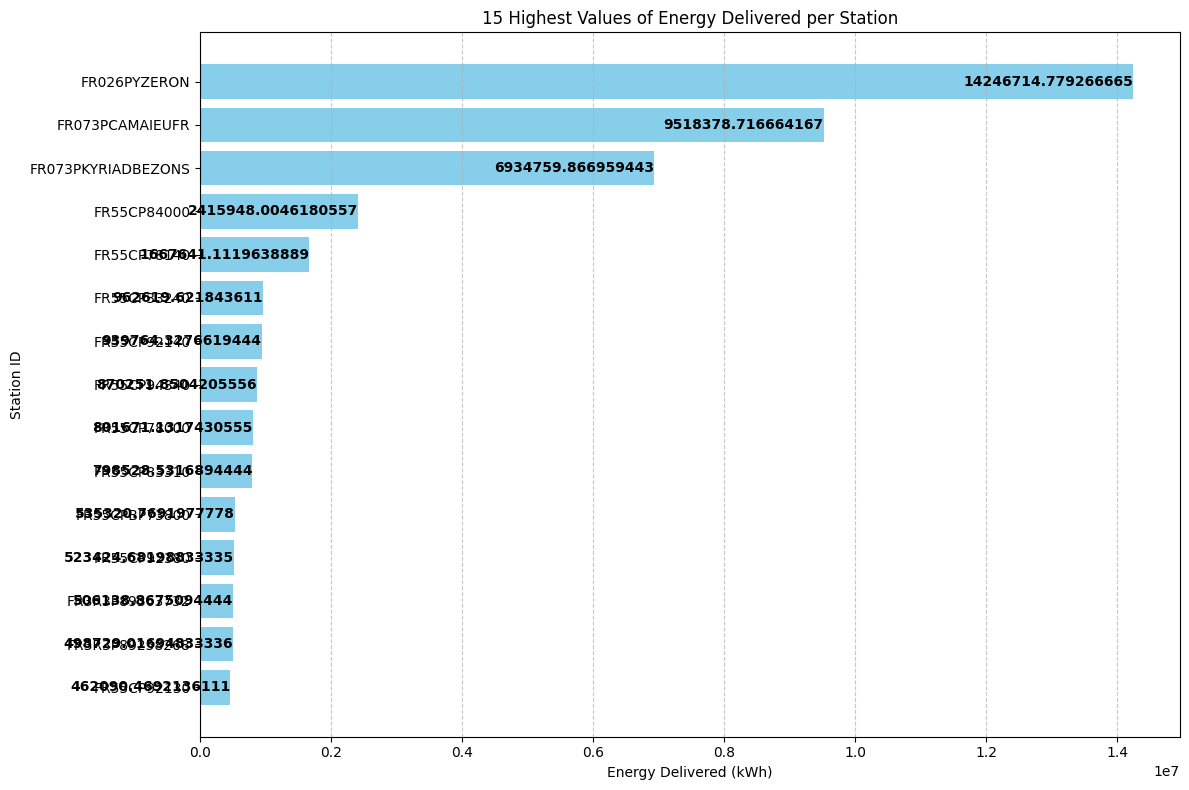

In [ ]:
# Sort the DataFrame by energy delivered in descending order and get the top 15
top_15_stations = energy_delivered_per_station.nlargest(15, 'energy_delivered_kWh')

# Create the horizontal bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_15_stations['station_id'], top_15_stations['energy_delivered_kWh'], color='skyblue')
plt.xlabel('Energy Delivered (kWh)')
plt.ylabel('Station ID')
plt.title('15 Highest Values of Energy Delivered per Station')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest values at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Annotate the bars with energy values
for index, value in enumerate(top_15_stations['energy_delivered_kWh']):
    plt.text(value, index, f'{value}', va='center', ha='right', color='black', fontweight='bold')

plt.show()

#Plug-in Time


In [ ]:
num_rows = len(df['session_id'])
print(num_rows)

588


In [ ]:
# Find all start and stop columns
start_columns = [col for col in df.columns if col.startswith('start')]
stop_columns = [col for col in df.columns if col.startswith('stop')]


column_pairs = [(start, stop) for start, stop in zip(start_columns, stop_columns) if start.replace('start', '') == stop.replace('stop', '')]

for start_col, stop_col in column_pairs:
    df = df.dropna(subset=[start_col, stop_col])

In [ ]:

total_difference = pd.Timedelta(0)



for start_col, stop_col in column_pairs:
    for index, row in df.iterrows():
        difference = row[stop_col] - row[start_col]
        total_difference += difference


average_difference = total_difference / num_rows

print(f'The average difference (sum(stop - start) / num_rows) is: {average_difference}')

The average difference (sum(stop - start) / num_rows) is: 0 days 05:32:17.725947278


# Total Charging sessions

In [ ]:
# Calculate sessions for different time periods
# Daily
df['day'] = df['start'].dt.date
daily_sessions = df.groupby(['session_id', 'day']).size().reset_index(name='num_sessions')
# Weekly
df['week'] = df['start'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_sessions = df.groupby(['session_id', 'week']).size().reset_index(name='num_sessions')
# Monthly
df['month'] = df['start'].dt.to_period('M')
monthly_sessions = df.groupby(['session_id', 'month']).size().reset_index(name='num_sessions')
# Annually
df['year'] = df['start'].dt.year
annual_sessions = df.groupby(['session_id', 'year']).size().reset_index(name='num_sessions')
print("\nDaily Sessions:")
print(daily_sessions)
print("\nWeekly Sessions:")
print(weekly_sessions)
print("\nMonthly Sessions:")
print(monthly_sessions)
print("\nAnnual Sessions:")
print(annual_sessions)



Daily Sessions:
     session_id         day  num_sessions
0         503.0  2020-08-13             1
1         509.0  2020-08-17             1
2         522.0  2020-08-21             1
3         524.0  2020-08-22             1
4         528.0  2020-08-23             1
..          ...         ...           ...
551      7114.0  2021-09-28             1
552      7119.0  2021-09-29             1
553      7142.0  2021-09-29             1
554      7184.0  2021-09-30             1
555      7190.0  2021-09-30             1

[556 rows x 3 columns]

Weekly Sessions:
     session_id       week  num_sessions
0         503.0 2020-08-10             1
1         509.0 2020-08-17             1
2         522.0 2020-08-17             1
3         524.0 2020-08-17             1
4         528.0 2020-08-17             1
..          ...        ...           ...
551      7114.0 2021-09-27             1
552      7119.0 2021-09-27             1
553      7142.0 2021-09-27             1
554      7184.0 2021-09-27 

<ipython-input-28-e947c27055b2>:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['start'].dt.to_period('W').apply(lambda r: r.start_time)
<ipython-input-28-e947c27055b2>:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['start'].dt.to_period('M')


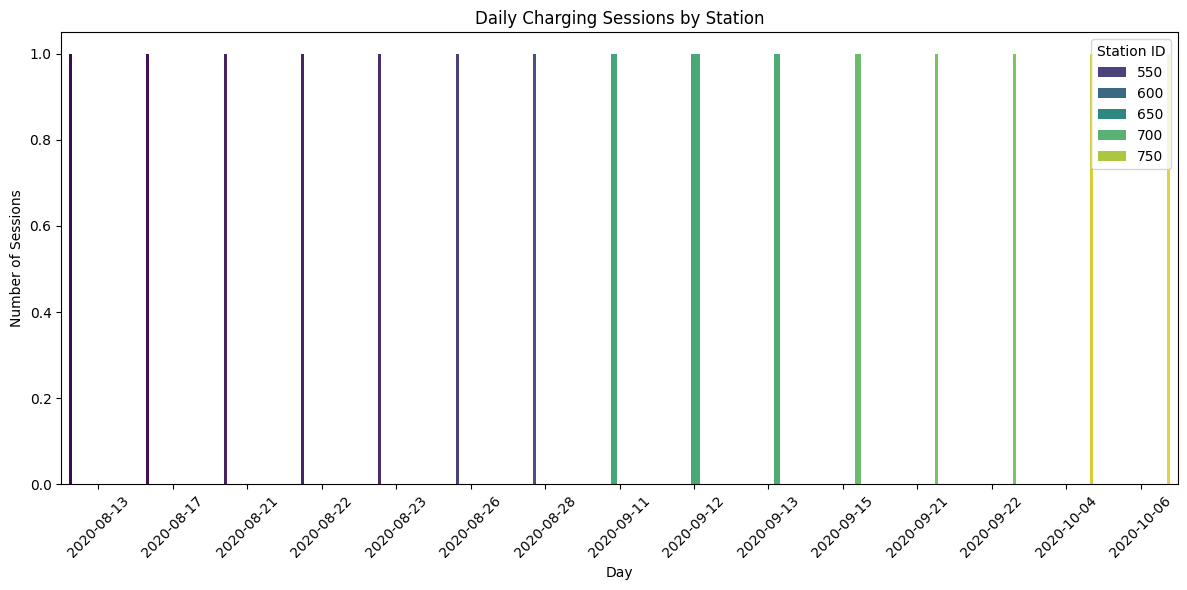

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

first_15_dates = daily_sessions['day'].unique()[:15]
filtered_daily_sessions = daily_sessions[daily_sessions['day'].isin(first_15_dates)]
plt.figure(figsize=(12, 6))
sns.barplot(x='day', y='num_sessions', hue='session_id', data=filtered_daily_sessions, palette='viridis')


plt.title('Daily Charging Sessions by Station')
plt.xlabel('Day')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.legend(title='Station ID')
plt.tight_layout()


plt.show()

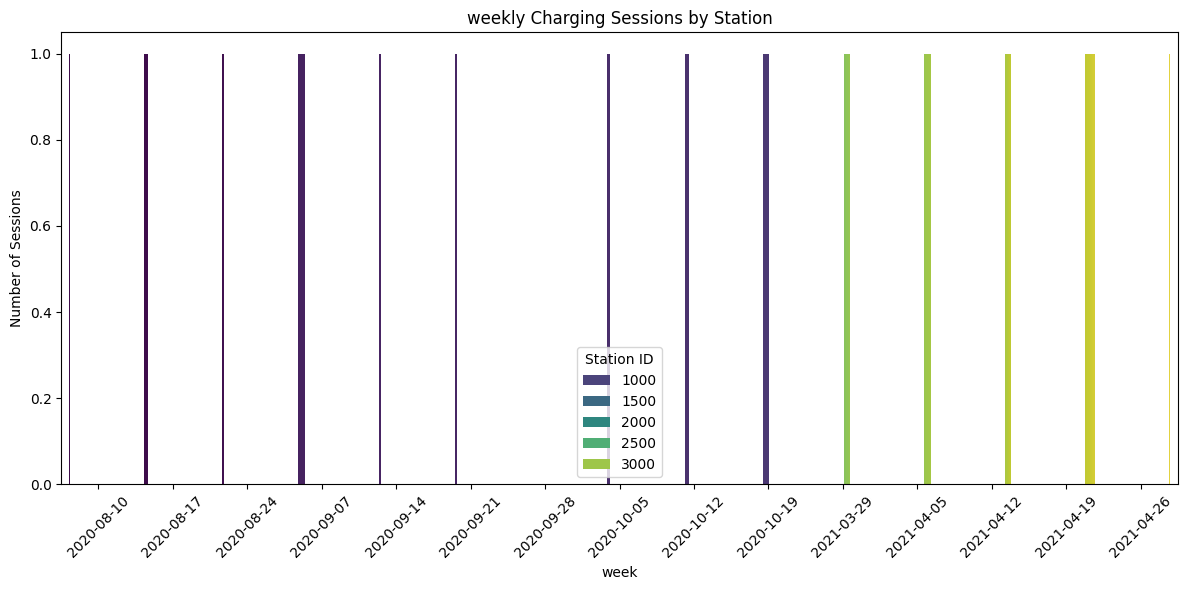

In [ ]:
first_15_weeks = weekly_sessions['week'].unique()[:15]
filtered_weekly_sessions = weekly_sessions[weekly_sessions['week'].isin(first_15_weeks)]
plt.figure(figsize=(12, 6))
sns.barplot(x='week', y='num_sessions', hue='session_id', data=filtered_weekly_sessions, palette='viridis')


plt.title('weekly Charging Sessions by Station')
plt.xlabel('week')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.legend(title='Station ID')
plt.tight_layout()


plt.show()

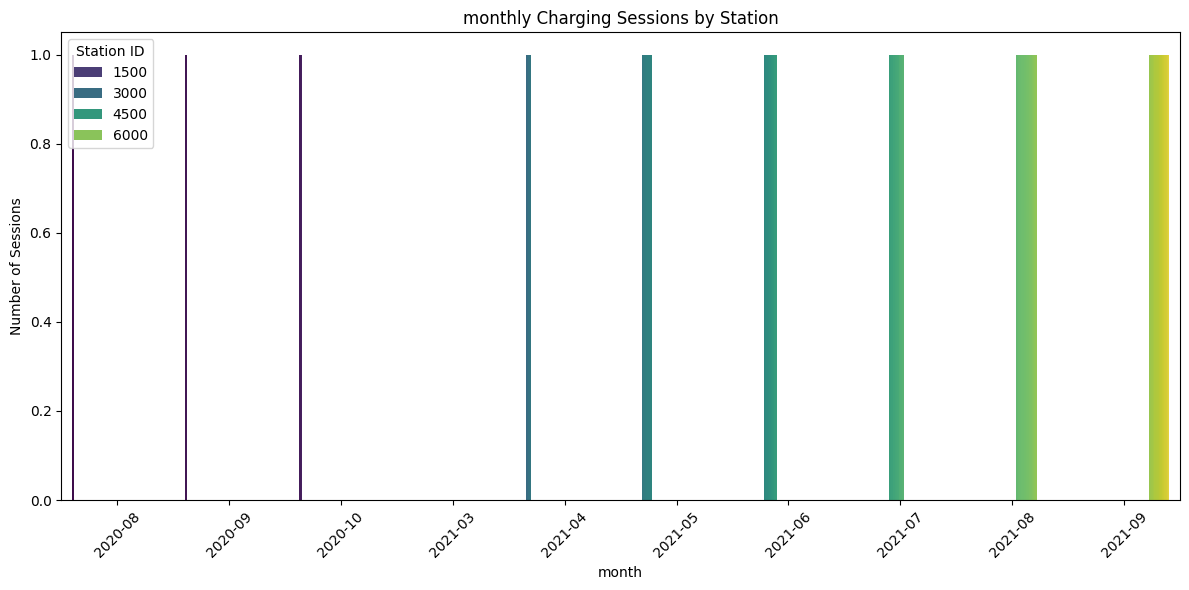

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='num_sessions', hue='session_id', data=monthly_sessions, palette='viridis')


plt.title('monthly Charging Sessions by Station')
plt.xlabel('month')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.legend(title='Station ID')
plt.tight_layout()


plt.show()

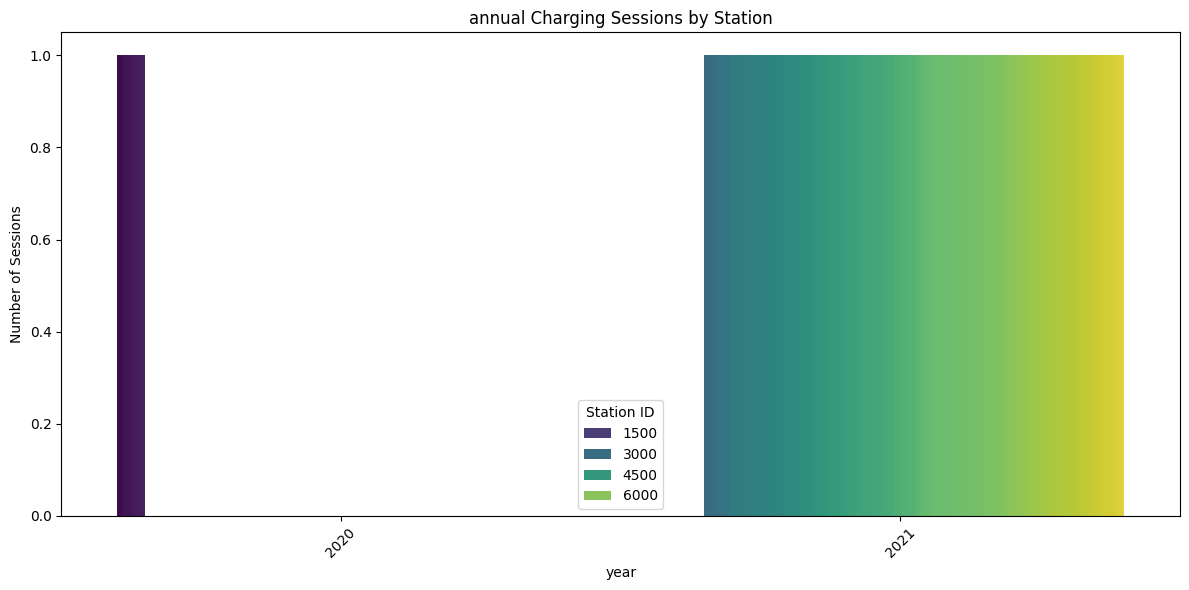

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='num_sessions', hue='session_id', data=annual_sessions, palette='viridis')


plt.title('annual Charging Sessions by Station')
plt.xlabel('year')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.legend(title='Station ID')
plt.tight_layout()


plt.show()

# Energy consumption

In [ ]:
df['day'] = df['start'].dt.date
daily_energy = df.groupby(['session_id', 'day'])['energy_wh'].sum().reset_index(name='total_energy_wh')
df['week'] = df['start'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_energy = df.groupby(['session_id', 'week'])['energy_wh'].sum().reset_index(name='total_energy_wh')
df['month'] = df['start'].dt.to_period('M')
monthly_energy = df.groupby(['session_id', 'month'])['energy_wh'].sum().reset_index(name='total_energy_wh')
df['year'] = df['start'].dt.year
annual_energy = df.groupby(['session_id', 'year'])['energy_wh'].sum().reset_index(name='total_energy_wh')




<ipython-input-47-936b87746cf3>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['start'].dt.to_period('W').apply(lambda r: r.start_time)
<ipython-input-47-936b87746cf3>:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['start'].dt.to_period('M')


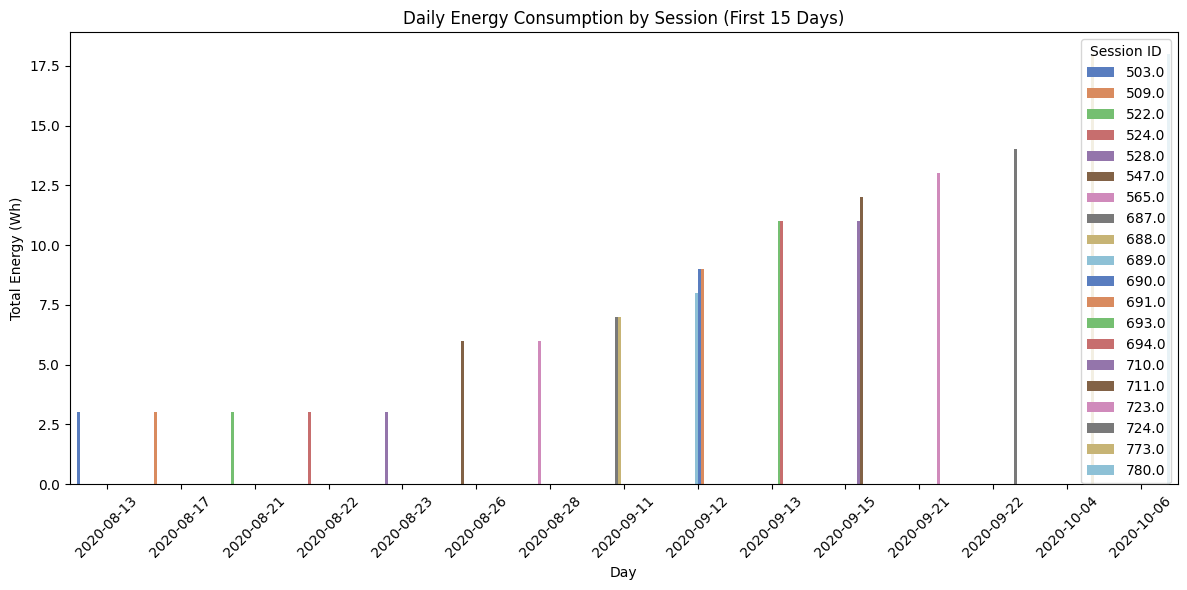

In [ ]:

first_15_days = daily_energy['day'].unique()[:15]
filtered_daily_energy = daily_energy[daily_energy['day'].isin(first_15_days)]


plt.figure(figsize=(12, 6))
sns.barplot(x='day', y='total_energy_wh', hue='session_id', data=filtered_daily_energy, palette='muted')


plt.title('Daily Energy Consumption by Session (First 15 Days)')
plt.xlabel('Day')
plt.ylabel('Total Energy (Wh)')
plt.xticks(rotation=45)
plt.legend(title='Session ID')
plt.tight_layout()


plt.show()

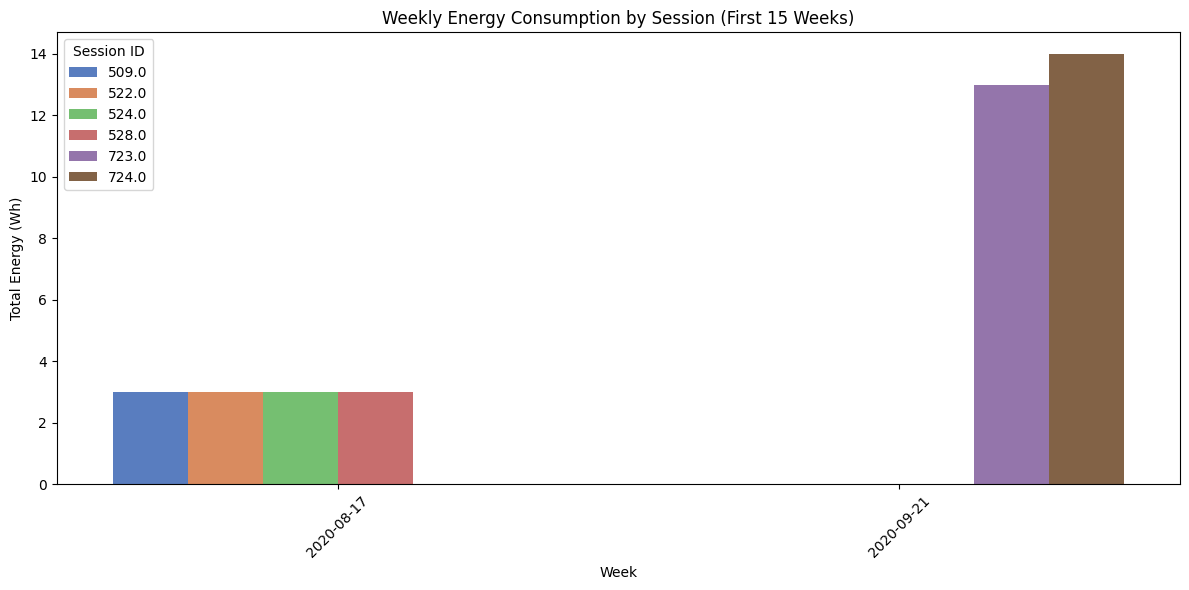

In [ ]:
first_15_weeks = weekly_energy['week'].unique()[:15]
filtered_weekly_energy = weekly_energy[weekly_energy['week'].isin(first_15_days)]


plt.figure(figsize=(12, 6))
sns.barplot(x='week', y='total_energy_wh', hue='session_id', data=filtered_weekly_energy, palette='muted')


plt.title('Weekly Energy Consumption by Session (First 15 Weeks)')
plt.xlabel('Week')
plt.ylabel('Total Energy (Wh)')
plt.xticks(rotation=45)
plt.legend(title='Session ID')
plt.tight_layout()


plt.show()

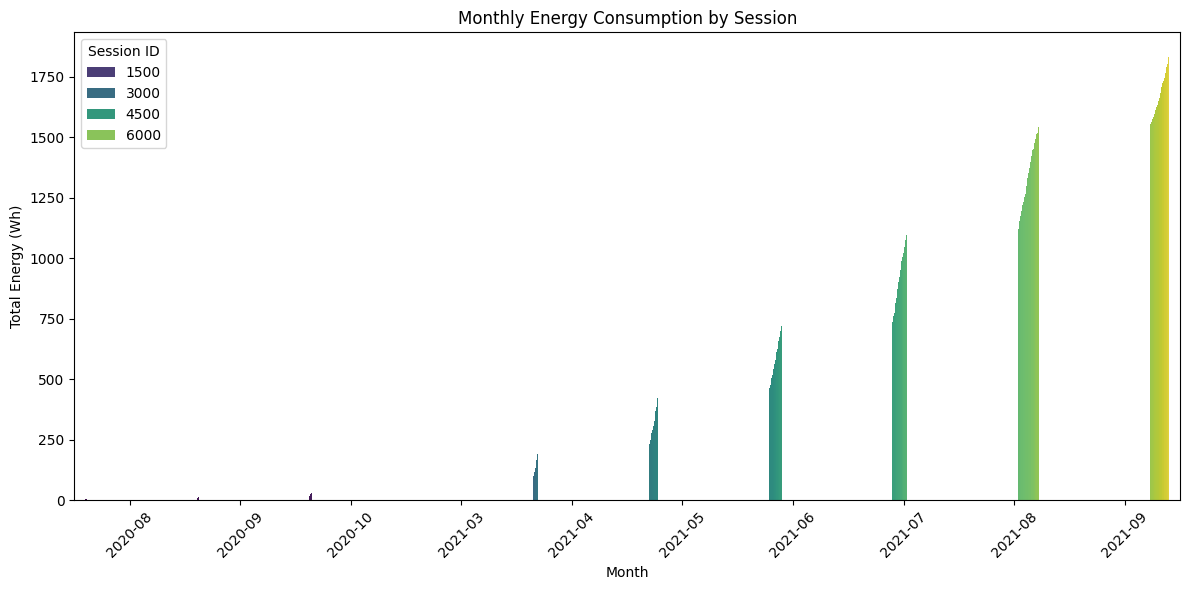

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='total_energy_wh', hue='session_id', data=monthly_energy, palette='viridis')


plt.title('Monthly Energy Consumption by Session')
plt.xlabel('Month')
plt.ylabel('Total Energy (Wh)')
plt.xticks(rotation=45)
plt.legend(title='Session ID')
plt.tight_layout()


plt.show()

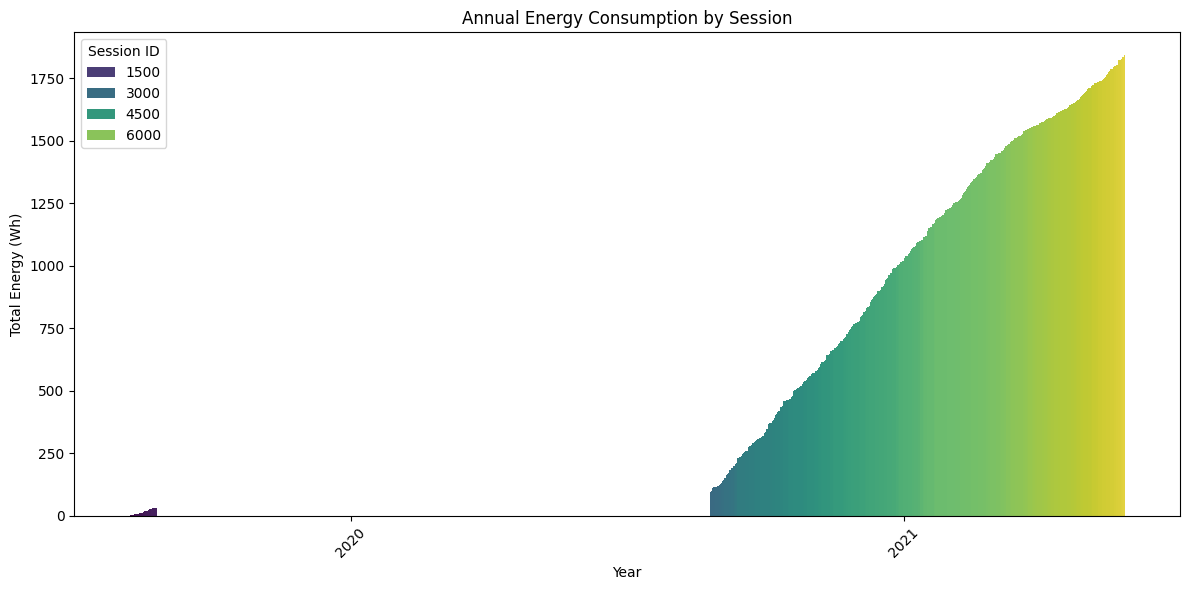

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='total_energy_wh', hue='session_id', data=annual_energy, palette='viridis')


plt.title('Annual Energy Consumption by Session')
plt.xlabel('Year')
plt.ylabel('Total Energy (Wh)')
plt.xticks(rotation=45)
plt.legend(title='Session ID')
plt.tight_layout()


plt.show()